Here, I will introduce the concept of expected goals (xG) and conduct an exploration of event data. Part II will be centered around constructing a machine-learning model from this event data, while Part III will explore the applications, strengths and deficiencies of this model. 

# What is xG?
Results in football, more so than any other sport, can be greatly influenced by random moments and “luck.” Near misses, deflected shots, goalkeeping errors, and controversial refereeing decisions alone can dictate the final result. Football is a game of inches. 

These effects are amplified by the fact that goals are rare events; a match produces 2.5 goals on average. Furthermore, a large majority of matches end in a draw or are decided by just a couple of goals, meaning a single goal can be largely significant to the result of a match. 

!

Luck and randomness can therefore have a notable effect when so many matches are defined by fine margins. This also makes performances difficult to evaluate; is a dogged 1-0 win a product of a deserving performance or a series of  fortunate events? Sometimes, this is difficult to evaluate with the naked eye. It is our hope to quantify and qualify performances by eliminating as much randomness as possible when examining a match. 

In order to score a goal, you must first attempt a shot at goal.  Assessing a performance ten or so years ago would simply entail taking a look at the total shots and shots on target. While these are useful tools for assessing chance creation, they do not tell the whole story as not all shots are created equal. There are many factors that influence the the likelihood of a shot resulting in a goal.


This is where xG comes into play. xG measures the probability that a shot will result in a goal based on a number of factors. Such factors include the distance from where the shot was taken, angle with respect to the goal line, the game state (what is the score), if it was a header, if the shot came during a counter attack and other factors. For the purpose of simplicity, our exploration will focus on just three of these factors. We can use this metric to sum over all the chances in a match to determine how many goals a team should have scored based on the factors we aggregated in our model. We can go even further to apply this to a stretch of games, a season or even a manager’s tenure.


xG therefore can serve as a gauge of how potent a team is in attack and how solid they are on the back. It can also be used to analyze a players ability to create shooting opportunities in dangerous areas and how well he takes his chances. In summary, the xG model helps us eliminate a portion of the random factors associated with scoring opportunities when we attempt to quantify a team's ability to score goals, which in the end is the ultimate goal of football.

We will see later that we can use xG to predict future results, guide decisions on player recruitment and evaluate coaching instructions, but first let’s try to explore some data. 

# Data Exploration

Before we get into building our xG model, we need to consider what sort of data we are interested in. Obviously, we need a large collection of shot data but more importantly we need the data to describe the type of shots that result in goals. We can deduce that the most important factors we need would be the distance from goal when the shot was taken, the angle with respect to the goal and what part of the body the shot was taken with. 

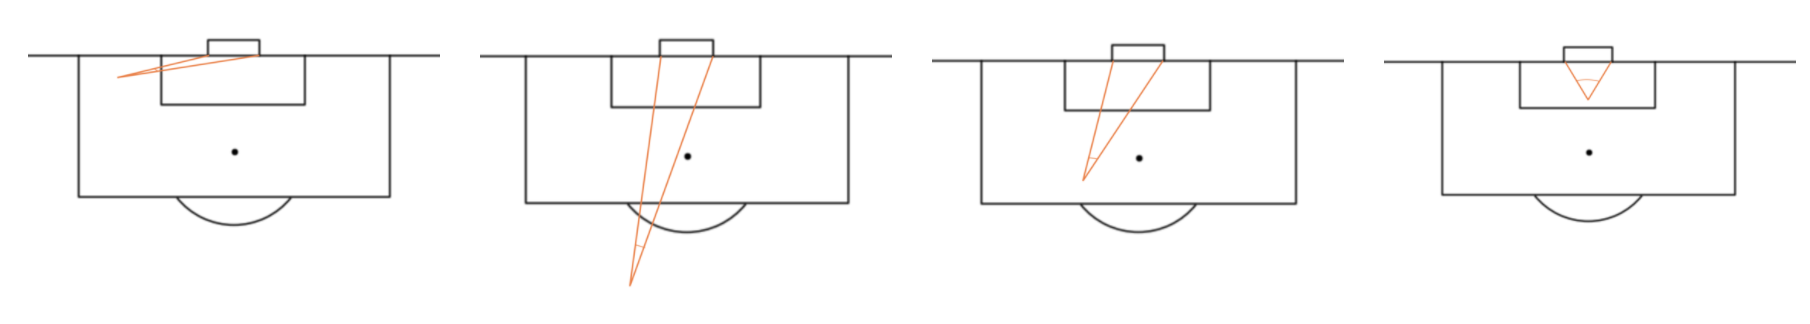


Football data is normally split into two forms: event data and tracking data. Event data records all on-ball events and where on the pitch they happened (such as shots, passes, tackles, dribbles), whereas tracking data records the positions of players and the ball through-out the game at regular intervals. 

The event data that I will use today comes from Wyscout. It covers all events from all matches across the top 5 domestics leagues in Europe (English Premier League, Ligue 1, Bundesliga, La Liga, Seria a) from the 2017/2018 season. 

While some of the findings in this section may seem elementary to those who have an extensive understanding of football, I always believe it is important to test our assumptions, as they can be misleading at times. I think the best place to start is to ask, where do most shots happen on the pitch? 

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

**Data Extraction and Wrangling**

First we have to import all the files that contain our event data. We will also import our libraries in the cell below.

In [3]:
#import pandas and numpy for data wrangling and manipulation
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
#I would love to upload this data to the github rep, but it is too large 
#thus please save it to a seperate folder on your computer and call it from there
#we need to load in our json files (where our event data is stored)
#https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
#I will be using the os library to create a list of the json files from my directory 
directory = '/Users/Ian/Desktop/IDanalytics/event_data'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
print(jsonfiles)

['/Users/Ian/Desktop/IDanalytics/event_data/events_France.json', '/Users/Ian/Desktop/IDanalytics/event_data/events_Spain.json', '/Users/Ian/Desktop/IDanalytics/event_data/events_Germany.json', '/Users/Ian/Desktop/IDanalytics/event_data/events_Italy.json', '/Users/Ian/Desktop/IDanalytics/event_data/events_England.json']


Now we are going to parse through the json files and extract all the relevent shot data to store in a tiddy seperate dataframe. Most of this will be done using the pandas and numpy library. 

In [4]:
def shot_matrix(eventdata):
    with open(eventdata) as f:
        data = json.load(f)
    
    #lets create the dataframe that we want to store our data in and all the attributes we are interested in 
    shots_dataset = pd.DataFrame(columns=['Goal','x','y','playerid','teamid','matchid','header'])
    
    #remember that the jsonfiles include passes, shots, tackles etc so we need to filter through these
    #lets find all the occurences of a shot within the set
    #refer to link in the prevous cell for info on the Wyscout event dataset, including tag names
    event_df = pd.DataFrame(data)
    all_shots = event_df[event_df['subEventName']=='Shot']
    
    #now we need to fill in our shots_dataset matrix by attribute columns
    #we will do this by filtering through the all-shot df (dataframe) we just made
    for index,shot in all_shots.iterrows():
        #here we fill in the columns for goals and headers with binary descripters
        shots_dataset.at[index,'Goal']=0
        shots_dataset.at[index,'header']=0
        for tag in shot['tags']:
            if tag['id']==101:
                shots_dataset.at[index,'Goal']=1
            elif tag['id']==403:
                shots_dataset.at[index,'header']=1
                
        #now we are interested in distance from the goal as well as the angle formed with the goal
        #Wyscouts pitch has its origin at the top left of the pitch and is 100m x 100m
        #therefore x and y represent percentage of nearness to top left corner 
        #most pitches are 105 meters by 68 so we will go with that
        shots_dataset.at[index,'Y']=shot['positions'][0]['y']*.68
        shots_dataset.at[index,'X']= (100 - shot['positions'][0]['x'])*1.05
        
        #now we use dummy variables x and y to calc distance and angle attributes
        shots_dataset.at[index,'x']= 100 - shot['positions'][0]['x'] 
        shots_dataset.at[index,'y']=shot['positions'][0]['y']
        shots_dataset.at[index,'Center_dis']=abs(shot['positions'][0]['y']-50)
        
        x = shots_dataset.at[index,'x']*1.05
        y = shots_dataset.at[index,'Center_dis']*.68
        shots_dataset.at[index,'Distance'] = np.sqrt(x**2 + y**2)
        
        #we are interested in the angle made between the width of the goal and the
        #straight line distance to the shot location. A goal is 7.32 meters wide
        #use the law of cosines
        c=7.32
        a=np.sqrt((y-7.32/2)**2 + x**2)
        b=np.sqrt((y+7.32/2)**2 + x**2)
        k = (c**2-a**2-b**2)/(-2*a*b)
        gamma = np.arccos(k)
        if gamma<0:
            gamma = np.pi + gamma
        shots_dataset.at[index,'Angle Radians'] = gamma
        shots_dataset.at[index,'Angle Degrees'] = gamma*180/np.pi
        
        #lastly we add the identifiers for player, team and match
        shots_dataset.at[index,'playerid']=shot['playerId']
        shots_dataset.at[index,'matchid']=shot['matchId']
        shots_dataset.at[index,'teamid']=shot['teamId']
        
        
    return shots_dataset
    

In [5]:
#Now we read in our json files into our shot_matrix function
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

/Users/Ian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in arccos


**Data Cleaning**

Now, before we get into exploring the dataset we just created, we should do some data cleaning. It it normal, especially with such a large collection of data, that there could have been some values inputed incorrectly, some values missing or just situations that we did not anticipate for. For example, we should check to see why we are encountering an error in arccos. 

In [6]:
#find out if the error is producing nan values
df.isnull().values.any()

True

In [7]:
#find how many such nan values
df.isnull().sum().sum()

6

In [8]:
df[df.isnull().any(axis=1)]

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
417224,1,0,49,4131,698,2565801,0,33.32,0.0,1.0,0.68,NaN,NaN
365140,1,0,52,224971,2445,2516954,0,35.36,0.0,2.0,1.36,NaN,NaN
499325,1,0,57,206314,3161,2576251,0,38.76,0.0,7.0,4.76,NaN,NaN


So it seems that there were some goals scored from the touch line which would require us to rethink how we created our construction of the angle attribute. Since there were only 3 occurences of such events and since they are normally unintentional rare events, I will remove them from our model. This is mainly to keep things simple.  

In [9]:
df.dropna()

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
213,1,6,57,256992,3799,2500686,0,38.76,6.30,7.0,7.896050,0.755576,43.291300
302,0,17,42,334552,3772,2500686,1,28.56,17.85,8.0,18.660549,0.372069,21.317963
498,1,4,43,26389,3772,2500686,0,29.24,4.20,7.0,6.348039,0.851948,48.813019
577,0,16,21,276920,3772,2500686,0,14.28,16.80,29.0,25.905953,0.184838,10.590449
629,0,27,51,366760,3799,2500686,0,34.68,28.35,1.0,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528


Now it seems we have some unnecessary columns that stored dummy variables when we computed distance and angles. Let's remove them.

In [10]:
df.drop(columns = ['x','y','Center_dis'])
df

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
213,1,6,57,256992,3799,2500686,0,38.76,6.30,7.0,7.896050,0.755576,43.291300
302,0,17,42,334552,3772,2500686,1,28.56,17.85,8.0,18.660549,0.372069,21.317963
498,1,4,43,26389,3772,2500686,0,29.24,4.20,7.0,6.348039,0.851948,48.813019
577,0,16,21,276920,3772,2500686,0,14.28,16.80,29.0,25.905953,0.184838,10.590449
629,0,27,51,366760,3799,2500686,0,34.68,28.35,1.0,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528


Great! We now have a tiddy dataset of all the shots taken in the 2017/2018 season. Now let's see what sort of relationship there is between shot result and distance and angle. I think the best way to do this is to vizualize the data. 

**Data Visualization**

The best place to start is to see how shots are distributed by distance and angle. 

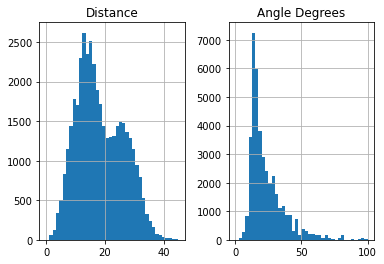

In [11]:
#plot distributions of shots by distance and angle side by side
fig, axes = plt.subplots(1, 2)
distance = df.hist("Distance",bins=40,range = (0,45),ax= axes[0])
angles = df.hist("Angle Degrees",bins=40, range = (0,100),ax=axes[1])

Right away, there are some conclusions we can draw. The distributions suggests that:

    1. A majority of shots happen between 10 and 20 meters. 

    2. Shots taken within about 6 meters are quite rare in comparison to shots taken outside 10 meters

    3. Oddly enough, there is a trough in the local region taken between 18m to about 25m

    4. As expected, players rarely take shots from angles less than 5 degrees, corresponding to central shots close to goal. 

The angle distribution agrees with the distance distribution in that shots taken from closer (larger angles) are much more difficult to produce.

Just with a simple distribution chart, we can conclude that it is quite difficult to produce shots that are close and central to goal. While we now know how shots are distributed by distance and angle, we have yet to address how shots that result in goals differ from those that do not.

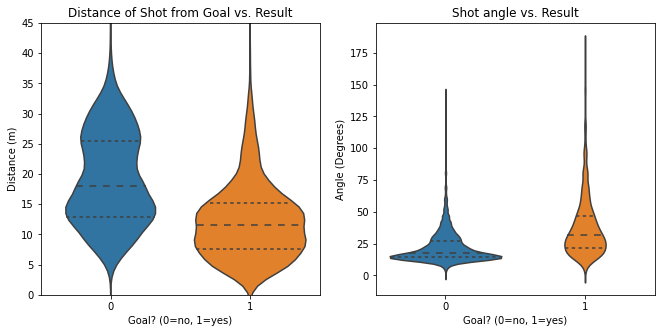

In [12]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))

#use seaborn lib for violin plot and extract necessary columns from our dataframe df
shot_dist = sns.violinplot(x="Goal", y="Distance",
                    data=df, inner="quart",ax= axes[0])
shot_dist.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Distance (m)",
       title="Distance of Shot from Goal vs. Result",ylim=(0, 45));

#similar as before
shot_ang = sns.violinplot(x="Goal", y="Angle Degrees",
                    data=df, inner="quart",ax = axes[1])
shot_ang.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Angle (Degrees)",
       title="Shot angle vs. Result");


The violin plot above plays a similar role to a box and whiskers plot but also provides use with the kernel distribution estimate of the data (essentially a smoothing of the distribution). In splitting up the data by the result of the shot, we can see that on average, shots that result in goals are taken from much closer to goal than shots that do not result in goals. The mean of shots resulting in goals is about 12 meters compared to about 18 meters for those that don't bulge the net. Similarly, goals are typically scored from angles of 20 degrees to about 50 degrees. 

So while it is difficult to produce shooting chances close to goal, the violin plot suggests that those that are close and central tend to result in goals.

Let's see how headers impact the mean and the distributions.

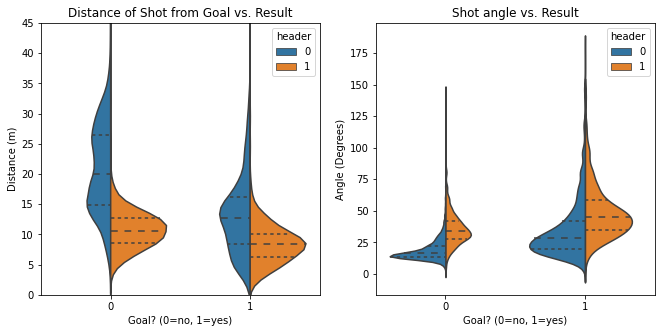

In [13]:
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
#the hue parameter splits plot by categorical data, in this case headers
shot_distance = sns.violinplot(x="Goal", y="Distance",hue='header',
                    data=df, inner="quart",split=True,ax = axes[0])
shot_distance.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Distance (m)",
       title="Distance of Shot from Goal vs. Result",ylim=(0, 45));

shot_ang = sns.violinplot(x="Goal", y="Angle Degrees",hue='header',
                    data=df, inner="quart",split=True,ax = axes[1])
shot_ang.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Angle (Degrees)",
       title="Shot angle vs. Result");

Headers, as we might expect, are normally taken within the 18 yard box (16.5 m). Interestingly the means and distributions of the results do not differ by much, so that is something we should consider down the line.

We have gained some fabulous insight through some basic distribution plots but we can take this a step further. We can better visualize how these variables impact the result by plotting the density of shots on a pitch. That is, we would like to split the pitch up into bins, calculate the number of shots taken within each bin and then use a color gradient to visualize how the density differs from bin to bin.

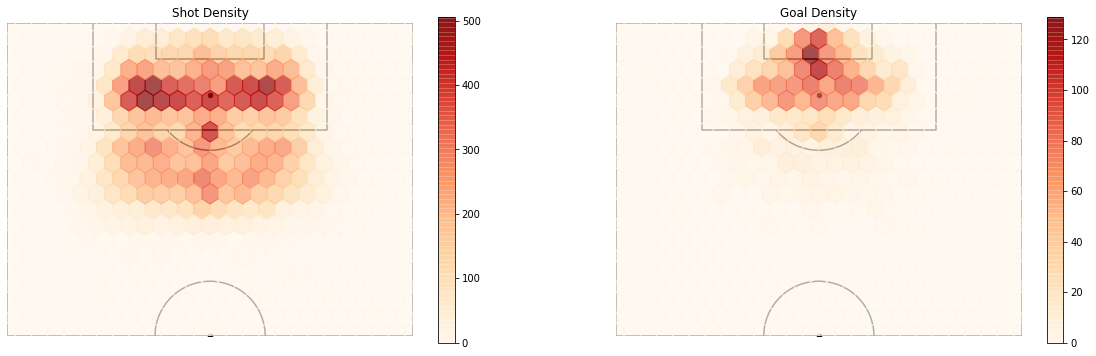

In [18]:
#import the pitch diagram
#refer to Patrick McKeever's guide to drawing pitches in Python
#http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
from PlotPitch import draw_pitch 

# Similar to the violin plot except we now plot all shots on the left and only goals on the right
fig, ax = plt.subplots(1,2,figsize=(20, 6))
plt.sca(ax[0])
#call our pitch diagram
#the goal here is to plot the density graph on top of the pitch
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[0])
#make sure we exclude headers for now
df_shots = df[df['header']==0]
#take a look at the matplotlib hexbon function for more detail
plt.hexbin(data =df_shots, x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[0].set_title('Shot Density')

#now for the goals
plt.sca(ax[1])
#look at only shots that resulted in goals
df_goals = df[(df['Goal']==1) & (df['header']==0)]
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[1])
plt.hexbin(data = df_goals,x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[1].set_title('Goal Density')

plt.show()


These density plots serve a similar function to the violin plots above but give us a much better visual understanding of which areas of the pitch normally produce shots and goals. This is because we can see how both distance and angle impact the distribution of shots on the same plot.

    1. As we learned with the violin plots:
        
    2. Shots are seldom taken from either side the box due to the poor angle

    3. A majority of the shots are taken around the penalty spot (11m)

    4. Goals are normally scored within 11 meters and within a very narrow passage

Before we delve deeper, we need to address why there is a sharp decrease in the number of shots on the edge of the box. This could be due to a number of reasons. 

    1.We have generalize that all football pitches are 105m x 68m when in reality every pitch has its own unique dimensions. The trough may be a product of our generalization.

    2.Another factor may be due to how Wyscout record their data. There may be an inclination to record a shot near the penalty box line as either inside the box or outside. Therefore it is possible that shots that happen on the line are being mischaracterized. 

    3.Lastly, there may be a psychological effect happening to the players. Players may resist the temptation to shoot when just outside the box in order to dribble into the box in the hope of winning a penalty. Defenders tend to defend much more tentatively when the opposition are in the box due to the possibility of a costly foul and it is possible that attackers want to take advantage of this. 

There are other possibilities and it is difficult to make any sort of conclusion regarding the trough but for now we will have to live with it. 

Now to return to some more data visualization. As you might guess, we can plot a probability density to assess which areas of the pitch have a high probability of a shot resulting in the goal and which do not.

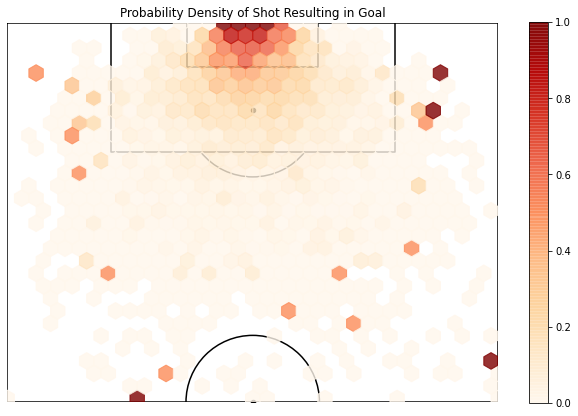

In [15]:
#probabilty density of shot resulting in goals
df_shots =df[df['header']==0]
prob=np.array(df_shots['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_shots,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.8,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Shot Resulting in Goal')

plt.show()

As expected, the closer you shoot from the goal, the more likely the shot is to result in a goal. Notice that there are certain outliers in which the probability density in those bin are very high. This is because of the few shots taken from those areas, they resulted in goals. If we had say 10 seasons of data, we would see a much more homogenous probability density.

One of the things that is most surprising to those who have never used xG is that the probability of scoring from beyond 11 meters out is in fact lower than maybe we appreciate when we see a game live. It is for this reason that this sort of analysis is important. We tend to over-estimate the quality of chance, such as shots from outside the box, when in fact there shots are quite difficult and inefficient. So, the next time your favorite player misses from 11 meters out, remember that he only really had a 3 in 10 chance of scoring anyway. 

Now what about headers?

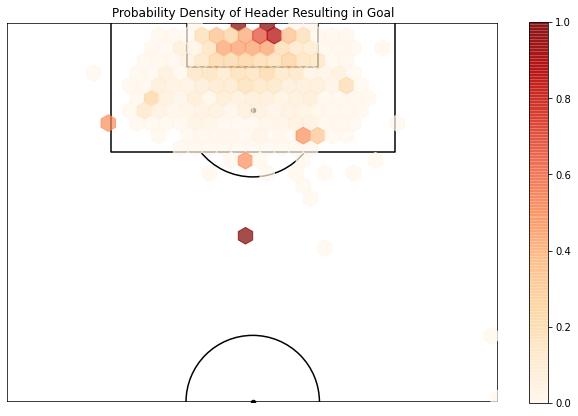

In [16]:
#probabilty density of headers resulting in goals 
df_header = df[df['header']==1]
prob=np.array(df_header['Goal'])

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_header,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.7,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Header Resulting in Goal')

plt.show()

While headers exhibit a similar trend to regular shots, they have lower probability values overall. This seems to suggest that while headers happen closer to goal on average, they also represent a much more difficult chance to put away. As we will see down the line, this is an important discovery and one that impacts our interpretation of chance evaluation.

Before we progress into some machine learning, I want to close with us trying to gain some insight into these trends. We have hypothesized that both the distance and the angle with the goal line affect the probability of a shot resulting in a goal and we have seen that with the graphs above. But what is the nature of this relationship? As we move away from the goal, how does the probability of scoring change? We can address these question as we have done before, with some well designed graphs.

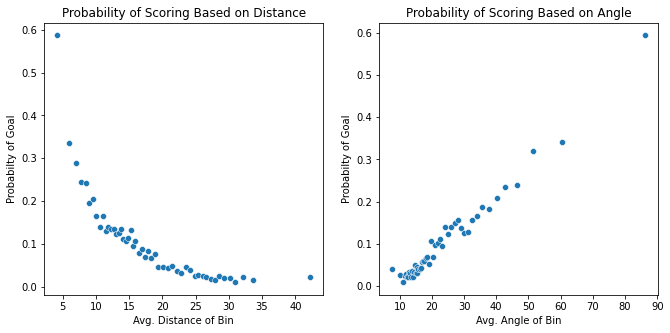

In [17]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=50)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob,ax=axes[0])
dist_trend.set(xlabel="Avg. Distance of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")

#same for the angle
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=50)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob,ax=axes[1])
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")


plt.show()

The first thing that pops out and is quite intriguing is that as we move further away from goal, the probability of scoring becomes exponentially more difficult. Now that is profound because it vastly diminishes the value of shots from distance. So why would this be? Up until now, we have ignored the fact that the angle with the goal decreases as we move away from the goal. So we have this sort of 'doubling factor' for the distance. We can hypothesize that this is because as we increase the distance a shot is taken from, it not only has a longer distance to travel but the target also becomes smaller.

Fantastic! Now we have seen the power of data visualization and how even the simplest graphs can help us discern the information locked behind large datasets. It is for this reason that spending time and effort on data exploration is so important. This will serve as a good foundation when we move onto some machine learning in the next part. See you soon!  